# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal
### Projet A2024
----
Équipe T - TODO
### Objectif
Prédiction de **la consommation en carburant de voitures récentes**.

### Données
Le jeu de données contient pour presque 400 véhicule, la consommation moyenne en L/100km, l'année de frabrication, le type de véhicule, le nombre de cylindre, cylindree, la transmission et la boite.

- `train.csv` est l'ensemble d'entraînement
- `test.csv` est l'ensemble de test


## Chargement des données

Importation des librairies utilisées dans le calepin.

// TODO: à enlever à la fin:

Pour importer librairies:
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"], ...)

In [742]:
#= import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("DecisionTree") =#

In [743]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, DecisionTree,Random, Plots

In [744]:
function standardize(data)
    return (data .- mean(data)) ./ std(data)
end

function standardize_data(data)
    stddata = deepcopy(data)
   for col in names(stddata)
        if eltype(stddata[!, col]) <: Number && col != "id"
            stddata[!, col] = standardize(stddata[!, col])
        end
    end
    return stddata
end

standardize_data (generic function with 1 method)

In [745]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end

function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :general_type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    return encoded_data
end

encode_data (generic function with 1 method)

In [746]:
function removeRows(data)
    return select!(data, Not([:type, :transmission, :boite, :general_type]))
end

removeRows (generic function with 1 method)

In [747]:
function add_general_type(data :: DataFrame)
    data = deepcopy(data)
    general_type_dict = Dict("voiture_moyenne" => "voiture", "VUS_petit" => "VUS", "voiture_compacte" => "voiture", "voiture_deux_places" => "voiture", "voiture_minicompacte" => "voiture", "VUS_standard" => "VUS", "monospace" => "camionnette", "voiture_sous_compacte" => "voiture", "camionnette_petit" => "camionnette", "break_petit" => "break", "voiture_grande" => "voiture", "camionnette_standard" => "camionnette", "break_moyen" => "break", "voiture_sport" => "voiture_sport")
    
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]

    data.type = ifelse.(data.type .== "voiture_deux_places"   .&& data.boite.=="manuelle" .&& data.cylindree .>= 4 , "voiture_sport" , data.type)

    #= println(sum(data.type .== "voiture_deux_places" .&& data.volume_gaz .> 45 .&& data.transmission .== "integrale" )) =#

    data.general_type = [general_type_dict[t] for t in data.type]
    return data
end



add_general_type (generic function with 1 method)

In [748]:
# sort(d[d.general_type .== "voiture_sport", :], :consommation, rev=true)

In [749]:
# add_general_type(testData)[testData.general_type .== "voiture_sport", :]

In [750]:
function add_rows(data)
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]

    # https://www.insurancenavy.com/average-car-weight/
    # https://www.auto-tests.com/fr/lightest-weight/Wagon/all/
    weight_dict = Dict("voiture_moyenne" => 3300, "VUS_petit" => 3500, "voiture_compacte" => 2800, "voiture_deux_places" => 2800, "voiture_minicompacte" => 1500, "VUS_standard" => 5000, "monospace" => 4500, "voiture_sous_compacte" => 2600, "camionnette_petit" => 4200, "break_petit" => 2640, "voiture_grande" => 4400, "camionnette_standard" => 4700, "break_moyen" => 3300)
    data[!, :weight] = [weight_dict[t] for t in data[!, :type]]

    data = add_general_type(data)
    
    # display(plot(data, x=:general_type, y=:consommation, color=:type))
    # println(combine(groupby(data, :type), nrow => :count))
    return data
end

add_rows (generic function with 1 method)

In [751]:
function getStandardEncodedData(data)
    data_copy = deepcopy(data)
    standardised_data = add_rows(data_copy)
    standardised_data = standardize_data(data_copy)
    # standardised_data = encode_data(standardised_data)
    standardised_data = removeRows(standardised_data)
    return standardised_data
end

    



getStandardEncodedData (generic function with 1 method)

In [752]:
function rmse(y, ychap)
    return sqrt(mean((ychap .- y).^2))
end


rmse (generic function with 1 method)

In [753]:
function rsquared(y, ychap)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- ychap).^2)
    return ss_res / ss_total
end


rsquared (generic function with 1 method)

In [754]:
function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

In [755]:
trainData = CSV.read("../../data/train.csv", DataFrame)
testData = CSV.read("../../data/test.csv", DataFrame)
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => "."))
testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))


COMSOMMATION_MEAN = mean(trainData.consommation)
COMSOMMATION_STD = std(trainData.consommation)
trainData[!, :id] = 1:nrow(trainData)
testData[!, :id] = 1:nrow(testData)
# trainData[!, :nrow] .= 1
# testData[!, :nrow] .= 1



1:150

In [756]:
function evaluate_rmse(data)
    nrange = 1000
    n = 0
    for i in range(0, 1, length=nrange)
        n += regression(data)[1]
    end
    print("average rmse for regression: ", n/nrange, "\n")
end


evaluate_rmse (generic function with 1 method)

In [757]:
function remise(prediction)
    id = 1:150
    df_pred = DataFrame(id=id, consommation=prediction)

   format_file(df_pred)
end

function format_file(predictions,i)
    #println(predictions)
    current_time = Dates.format(now(), "yyyy-mm-dd_HH-MM-SS")
    file_name = "benchmark_$i.csv"
    CSV.write("./" *file_name, predictions)
end

format_file (generic function with 1 method)

In [758]:
# findnearest(A::Vector{Float64},t::Float64) = A[findmin(broadcast(abs,A.-t))[2]]

# function findnearest(A::Vector{Float64},t::Float64)
#     nearest_value = A[1]
#     smallest_diff = abs(A[1] - t)
#     for value in A
#         diff = abs(value - t)
#         if diff < smallest_diff
#             smallest_diff = diff
#             nearest_value = value
#         end
#     end
#     if smallest_diff > 0.3
#         # println("Warning: the nearest value is ", nearest_value, " the value was ", t," with a difference of ", smallest_diff)
#     end
#     return nearest_value
    
# end


In [759]:
# getStandardEncodedData(trainData)

In [760]:
function get_unique_data(data, columns_to_compare)

    # group_sizes = combine(groupby(data, columns_to_compare), nrow => :count)
    # small_groups = filter(row -> row.count < 3, group_sizes)

    # for row in eachrow(small_groups)
    #     group = filter(all([data[!, col] .== row[col] for col in columns_to_compare]), data)
    #     if nrow(group) < 3
    #         adjacent_values = filter(all([data[!, col] .!= row[col] for col in columns_to_compare]), data)
    #         group.consommation .= mean(adjacent_values.consommation)
    #     end
    # end

    
    # data[!, :consommation] .= data[!, :consommation] .* data[!, :nrow]
    unique_data = combine(groupby(data, columns_to_compare), :consommation => mean)
    rename!(unique_data, :consommation_mean => :consommation)
#=     unique_data = add_rows(unique_data)
 =#    return unique_data
end

function find_pairs(data_train, data_predict, columns_to_compare)
    train_data_without_consommation = select(data_train, Not(:consommation))
    # print(train_data_without_consommation)
    predict_data_without_annee = select(data_predict, Not(:annee))
    # print(predict_data_without_annee)

    #println(names(train_data_without_consommation))

    common_values = innerjoin(data_train, data_predict, on=columns_to_compare)

    #println(common_values.id)
    # print(common_values)
    return common_values
end

function find_differents(data_train, data_predict)
    different_values = antijoin(data_predict, data_train, on=COLUMNS_TO_COMPARE)
    return different_values
    
end

function predict_with_dups(data_train, data_predict, raw_data_train, raw_data_predict)
    pairs = find_pairs(raw_data_train, raw_data_predict)
    pairs = select(pairs, [:id, :consommation])

    different_values = find_differents(raw_data_train, raw_data_predict)
    # println(different_values)

    beta = regression(data_train, 0.0)[2]

    data_predict = getStandardEncodedData(different_values[!, Not(:id)])


    data_predict = Matrix(data_predict[:, names(data_train[:, Not(:consommation)])])
    println(data_predict)

    prediction_differents = data_predict * beta


    prediction_differents = (prediction_differents .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN

    prediction_differents = DataFrame(id=different_values.id, consommation=prediction_differents)

    # print(prediction_differents)
    # print(pairs)

    prediction = vcat(pairs, prediction_differents)
    prediction = sort(prediction, :id)
    # println(prediction)

    # print(prediction)
    return prediction
end
    
    

predict_with_dups (generic function with 1 method)

In [761]:
function linear_regression(data, x_col, y_col)
    # Extract x and y data from the DataFrame
    x = data[!, x_col]
    y = data[!, y_col]
    
    # Ensure there is enough data for the calculation
    n = length(x)
    if n == 0
        error("Cannot compute linear regression with zero elements.")
    end
    
    # Calculate the mean values
    x_mean = mean(x)
    y_mean = mean(y)
    
    # Calculate slope and intercept for linear regression
    slope = sum((x .- x_mean) .* (y .- y_mean)) / sum((x .- x_mean).^2)
    intercept = y_mean - slope * x_mean
    
    return slope, intercept
end

linear_regression (generic function with 1 method)

In [762]:

function get_outliers_ind_regression_lin(data, x_col, y_col; threshold=2.5)
    slope, intercept = linear_regression(data, x_col, y_col)
    
    x = data[!, x_col]
    y = data[!, y_col]
    
    y_pred = slope .* x .+ intercept
    
    residuals = abs.(y .- y_pred)
    
    residuals_std = std(residuals)
    
    outlier_indices = findall(residuals .> threshold * residuals_std)
    

    for idx in outlier_indices
        # println("Outlier detected at row $idx: ", "x = ", x[idx], ", y = ", y[idx], ", Residual = ", residuals[idx])
    end

    outliers = data[outlier_indices, :]
    
    return outlier_indices
end


get_outliers_ind_regression_lin (generic function with 1 method)

In [763]:
function get_outliers_regression_lin(data, outliers_indices)
    outliers = data[outliers_indices, :]
    return outliers
end;

In [764]:
function remove_outliers_regression_lin(data::DataFrame, x_col::Symbol, y_col::Symbol; threshold=2.5)
    outlier_indices = get_outliers_ind_regression_lin(data, x_col, y_col, threshold=threshold)

    # println("Outlier Indices Identified: ", outlier_indices)

    keep_mask = trues(nrow(data))
    
    if !isempty(outlier_indices)
        keep_mask[outlier_indices] .= false
    end

    cleaned_data = data[keep_mask, :]
    
    return cleaned_data
end

remove_outliers_regression_lin (generic function with 1 method)

In [765]:
 function plot_outliers(uniqueD)
 # Step 2: Find and Display Outliers with Regression
 outliers_indices = get_outliers_ind_regression_lin(uniqueD, :cylindree, :consommation)
 outliers_regression = get_outliers_regression_lin(uniqueD, outliers_indices)

 # Step 3: Plot Original Data, Regression Line, and Outliers
 slope, intercept = linear_regression(uniqueD, :cylindree, :consommation)
 regression_line_y = slope .* uniqueD.cylindree .+ intercept

 layer_original = layer(x=uniqueD.cylindree, y=uniqueD.consommation, color=uniqueD.type, Theme(default_color="blue"))
 layer_linear_regression = layer(x=uniqueD.cylindree, y=regression_line_y, Geom.line, Theme(default_color="green"))
 layer_regression_outliers = layer(x=outliers_regression.cylindree, y=outliers_regression.consommation, Geom.point, Theme(default_color="red"))

 
 display(plot(layer_regression_outliers, layer_original, layer_linear_regression, Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Original Data with Outliers")))

 # Step 4: Remove Outliers Based on Regression Line
 cleaned_data = remove_outliers_regression_lin(uniqueD, :cylindree, :consommation, threshold=2.5)

 # Step 5: Plot Cleaned Data with New Regression Line
 slope_cleaned, intercept_cleaned = linear_regression(cleaned_data, :cylindree, :consommation)
 regression_line_y_cleaned = slope_cleaned .* cleaned_data.cylindree .+ intercept_cleaned

layer_cleaned = layer(x=cleaned_data.cylindree, y=cleaned_data.consommation, color=cleaned_data.type, Theme(default_color="blue"))
layer_linear_regression_cleaned = layer(x=cleaned_data.cylindree, y=regression_line_y_cleaned, Geom.line, Theme(default_color="green"))

# Display plot for cleaned data
display(plot(layer_cleaned, layer_linear_regression_cleaned, 
             Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Cleaned Data with Regression Line")))

end

plot_outliers (generic function with 1 method)

In [766]:
function regression(standardised_data, trainTestSplitPercentage = 0.2)
    training_data, test_data = train_test_split(standardised_data, trainTestSplitPercentage)

    X_train =  Matrix(training_data[:, Not(:consommation)])
    y_train = training_data[:, :consommation]

    beta = X_train \ y_train

    rmseval = 0.0
    if trainTestSplitPercentage != 0.0
        X_test = Matrix(test_data[:, Not(:consommation)])
        y_test = test_data[:, :consommation]
        ychap =  X_test * beta
        ychap = (ychap .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        y_test = (y_test .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        rmseval = rmse(y_test, ychap)
    end
    
    return rmseval, beta, training_data, test_data
end

regression (generic function with 2 methods)

In [767]:
function remise_regression(beta)
    test_data = getStandardEncodedData(testData)
    X_test = Matrix(test_data[!,Not(:id)])
    ychap =  X_test * beta
    # ychap = (ychap .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    remise(ychap)
end


remise_regression (generic function with 1 method)

In [768]:
d= add_rows(trainData)
d = encode_data(d)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,id,volume_gaz,weight,general_type,voiture,VUS,camionnette,break,voiture_sport,integrale,propulsion,traction,4x4,automatique,manuelle
,Int64,Abstract…,Int64,Float64,String15,String15,Float64,Int64,Float64,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2023,voiture_moyenne,8,4.4,integrale,automatique,13.8359,1,35.2,3300,voiture,1,0,0,0,0,1,0,0,0,1,0
2,2020,VUS_petit,4,2.0,integrale,automatique,9.80042,2,8.0,3500,VUS,0,1,0,0,0,1,0,0,0,1,0
3,2021,voiture_compacte,6,3.3,propulsion,automatique,11.7605,3,19.8,2800,voiture,1,0,0,0,0,0,1,0,0,1,0
4,2023,voiture_deux_places,8,5.0,integrale,automatique,13.0672,4,40.0,2800,voiture,1,0,0,0,0,1,0,0,0,1,0
5,2022,voiture_moyenne,8,4.4,integrale,automatique,13.8359,5,35.2,3300,voiture,1,0,0,0,0,1,0,0,0,1,0
6,2022,voiture_moyenne,8,4.4,integrale,automatique,13.8359,6,35.2,3300,voiture,1,0,0,0,0,1,0,0,0,1,0
7,2022,voiture_minicompacte,3,1.5,traction,automatique,7.35031,7,4.5,1500,voiture,1,0,0,0,0,0,0,1,0,1,0
8,2024,voiture_minicompacte,3,1.5,traction,manuelle,7.58742,8,4.5,1500,voiture,1,0,0,0,0,0,0,1,0,0,1
9,2020,VUS_standard,6,3.8,integrale,automatique,11.2005,9,22.8,5000,VUS,0,1,0,0,0,1,0,0,0,1,0


In [769]:
d = removeRows(d)

Row,annee,nombre_cylindres,cylindree,consommation,id,volume_gaz,weight,voiture,VUS,camionnette,break,voiture_sport,integrale,propulsion,traction,4x4,automatique,manuelle
,Int64,Int64,Float64,Float64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2023,8,4.4,13.8359,1,35.2,3300,1,0,0,0,0,1,0,0,0,1,0
2,2020,4,2.0,9.80042,2,8.0,3500,0,1,0,0,0,1,0,0,0,1,0
3,2021,6,3.3,11.7605,3,19.8,2800,1,0,0,0,0,0,1,0,0,1,0
4,2023,8,5.0,13.0672,4,40.0,2800,1,0,0,0,0,1,0,0,0,1,0
5,2022,8,4.4,13.8359,5,35.2,3300,1,0,0,0,0,1,0,0,0,1,0
6,2022,8,4.4,13.8359,6,35.2,3300,1,0,0,0,0,1,0,0,0,1,0
7,2022,3,1.5,7.35031,7,4.5,1500,1,0,0,0,0,0,0,1,0,1,0
8,2024,3,1.5,7.58742,8,4.5,1500,1,0,0,0,0,0,0,1,0,0,1
9,2020,6,3.8,11.2005,9,22.8,5000,0,1,0,0,0,1,0,0,0,1,0


In [770]:
using LinearAlgebra

function fit_ridge_regression(X::DataFrame, y::Vector, lambda::Float64)
    X = mapcols(x -> (x.-mean(x))/std(x), X)
    X = Matrix(X)
    beta = (X'X + lambda * I) \ (X'y)
    return beta
end

# Example usage
lambda = 0.3

beta = fit_ridge_regression(d[:, Not(:consommation, :id)], d.consommation, lambda)
betas = DataFrame(colnames=names(d[:, Not(:consommation, :id)]), beta=beta, abs=abs.(beta))

colToIndex = Dict("cylindree" => "cylindree", "nombre_cylindres" => "nombre_cylindres", "volume_gaz" => "volume_gaz", "weight" => "weight", "voiture" => "general_type", "VUS" => "general_type", "voiture_sport" => "general_type", "camionnette" => "general_type", "break" => "general_type", "manuelle" => "boite", "automatique" => "boite", "integrale" => "transmission", "traction" => "transmission", "propulsion" => "transmission", "4x4" => "transmission", "annee" => "annee")

betas.colType = [colToIndex[c] for c in betas.colnames]

combined_betas = combine(groupby(betas, :colType), :abs => maximum)

#= filtered_betas = filter(row -> row.colType in, combined_betas)
 =#
sort(combined_betas, :abs_maximum, rev=true)

Row,colType,abs_maximum
,String,Float64
1,cylindree,1.0133
2,nombre_cylindres,0.996866
3,transmission,0.329464
4,volume_gaz,0.30483
5,general_type,0.187735
6,boite,0.0878455
7,weight,0.0497366
8,annee,0.00390767


In [771]:
COLUMNS_TO_COMPARE_1 = ["type", "nombre_cylindres", "cylindree", "transmission", "boite"]
# COLUMNS_TO_COMPARE_2 = ["nombre_cylindres", "cylindree", "transmission", "type" ]
COLUMNS_TO_COMPARE_3 = ["nombre_cylindres", "cylindree", "type" ]
COLUMNS_TO_COMPARE_4 = ["nombre_cylindres", "cylindree"]
COLUMNS_TO_COMPARE_5 = ["cylindree"]

trainData.type = ifelse.(trainData.type .== "break_petit", "break_moyen", trainData.type)
testData.type = ifelse.(testData.type .== "break_moyen", "break", testData.type)
testData.type = ifelse.(testData.type .== "camionnette_standard", "cam", testData.type)

trainData = filter(row -> row.type != "monospace", trainData)
# trainData.type = ifelse.(trainData.type .== "monospace", "mono", trainData.type)


# attention à la ligne suivante vraiment pas sur
# testData.type = ifelse.(testData.type .== "break_petit", "break", testData.type)


trainData.type = ifelse.(trainData.type .== "voiture_deux_places" .&& trainData.nombre_cylindres .>= 8 .&& trainData.boite .== "manuelle" .&& trainData.transmission .== "integrale", "voiture_sport", trainData.type)
testData.type = ifelse.(testData.type .== "voiture_deux_places" .&& testData.nombre_cylindres .>= 8 .&& testData.boite .== "manuelle" .&& testData.transmission .== "integrale", "voiture_sport", testData.type)

function main(trainData, testData)
    uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_1)
    pairs = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_1)
    print(pairs.id)
    pairs = select(pairs, [:id, :consommation])
    testData = filter(row -> !(row.id in pairs.id), testData)
    # println("pairs_1")
    # println(pairs)


    uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_3)
    pairs_2 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_3)
    pairs_2 = select(pairs_2, [:id, :consommation])
    # println("pairs_2")
    # println(pairs_2)
    pairs = vcat(pairs, pairs_2)
    testData = filter(row -> !(row.id in pairs.id), testData)





    uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_4)
    pairs_3 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_4)
    pairs_3 = select(pairs_3, [:id, :consommation])
    pairs = vcat(pairs, pairs_3)
    testData = filter(row -> !(row.id in pairs.id), testData)


    # uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_5)
    # pairs_4 = find_pairs(uniqueD, testData, COLUMNS_TO_COMPARE_5)
    # pairs_4 = select(pairs_4, [:id, :consommation])
    # pairs = vcat(pairs, pairs_4)
    # testData = filter(row -> !(row.id in pairs.id), testData)

    # average= (15.6806666666667 + 13.8358823529412)/2 
    pairs_5 = DataFrame(id=5, consommation=13.8358823529412)
    pairs = vcat(pairs, pairs_5)
    testData = filter(row -> !(row.id in pairs.id), testData) 
    # print(testData)

    # vcat(pairs_1, pairs_2, pairs_3, pairs_4, pairs_5)

    # println(pairs_2.id)

    sort!(pairs, :id)

    # format_file(pairs,20)

    return pairs, pairs_2

end
out, pairs_2 = main(trainData, testData)

[1, 2, 3, 4, 6, 7, 8, 9, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 46, 47, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 71, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 105, 106, 108, 109, 111, 114, 116, 117, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]

(150×2 DataFrame
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   1 │     1       8.11069
   2 │     2       7.59532
   3 │     3       8.66848
   4 │     4       8.71148
   5 │     5      13.8359
   6 │     6      13.8359
   7 │     7      13.8359
   8 │     8      10.2265
   9 │     9      10.9459
  10 │    10      14.4124
  11 │    11      14.4124
  ⋮  │   ⋮         ⋮
 141 │   141      12.6546
 142 │   142      10.1294
 143 │   143       9.30079
 144 │   144       7.53425
 145 │   145       8.60777
 146 │   146       8.87901
 147 │   147      11.7605
 148 │   148      10.9173
 149 │   149       7.58742
 150 │   150       7.93627
           129 rows omitted, 15×2 DataFrame
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   1 │   119      11.2005
   2 │    39       8.29229
   3 │    45       8.29229
   4 │   132       8.29229
   5 │    68      12.9347
   6 │    69      12.9347
   7 │    70      12.9347
   8 │   

In [772]:
function tree_regression(training_data, test_data, out)
   
    common_ids = [1, 2, 3, 4, 6, 7, 8, 9, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 46, 47, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 71, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 103, 104, 105, 106, 108, 109, 111, 114, 116, 117, 120, 121, 122, 123, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]

    # j'ai retiré 81

    y_train = training_data.consommation
    common_columns = intersect(names(training_data), names(test_data))
    println(common_columns)
    training_data = training_data[:, common_columns]
    test_data = test_data[:, common_columns]

    out = filter(row -> (row.id in common_ids), out)


    X_train = Matrix(training_data[:, Not(:annee, :id)])

    X_test = Matrix(test_data[:, Not(:annee, :id)])
    # y_test = test_data.consommation

    

    
    model = RandomForestRegressor(n_subfeatures=5, n_trees=1000,min_samples_leaf=1,min_purity_increase=0.0, max_depth=5, min_samples_split=6)
    # model = DecisionTreeRegressor(max_depth=5)
    fit!(model, X_train, y_train)
    ychap =  predict(model, X_test)  



    prediction = DataFrame(id=1:150, consommation=ychap)


    prediction = filter(row -> !(row.id in common_ids), prediction)

    # print(out)


    prediction = vcat(prediction, out)


    sort!(prediction, :id)




    # println(prediction)


    return prediction









    
end

tree_regression (generic function with 1 method)

In [773]:
# print(trainData)
ptree = tree_regression(trainData, testData, out)

idcheck = 5



difference = ptree.consommation - out.consommation

diff_df = DataFrame(id=ptree.id, diff=difference)

filtered_diff_df = filter(row -> abs(row.diff) > 0.3, diff_df)

println(filtered_diff_df)


average_data = (out.consommation .+ ptree.consommation) ./ 2

average_data = DataFrame(id=1:150, consommation=average_data)


# format_file(average_data, 105)

# average_data = ptree
println(ptree[idcheck,:])
println(out[idcheck,:])
println(average_data[idcheck,:])


# 5, 49, 72, 107




["annee", "type", "nombre_cylindres", "cylindree", "transmission", "boite", "id"]
18×2 DataFrame
 Row │ id     diff      
     │ Int64  Float64   
─────┼──────────────────
   1 │    10   1.37576
   2 │    11   1.37576
   3 │    17   0.304719
   4 │    18   0.304719
   5 │    19   0.396781
   6 │    20   0.396781
   7 │    49   0.81771
   8 │    69   0.453334
   9 │    72   1.64825
  10 │    81  -0.458212
  11 │    88   0.77417
  12 │    98  -0.637211
  13 │   107   1.21396
  14 │   112  -0.637211
  15 │   115  -0.394781
  16 │   118  -0.392452
  17 │   124  -0.44419
  18 │   125  -0.44419
DataFrameRow
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   5 │     5       13.8717
DataFrameRow
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   5 │     5       13.8359
DataFrameRow
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   5 │     5       13.8538


In [774]:
# t = trainData[trainData.type .== "VUS_petit" .&& trainData.nombre_cylindres .==4 .&& trainData.cylindree .== 1.5,:]
# # 124 et 125
# println(mean(t.consommation))

In [775]:
# t = trainData[trainData.type .== "camionnette_petit" .&& trainData.nombre_cylindres .==4 .&& trainData.cylindree .== 2.5,:]
# 118
# println(mean(t.consommation))

In [776]:
t = trainData[ trainData.nombre_cylindres .>= 6 .&& trainData.boite .=="manuelle",:]
# 10, 11
# println(mean(t.consommation))

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,id,volume_gaz,weight
,Int64,Abstract…,Int64,Float64,String15,String15,Float64,Int64,Float64,Int64
1,2014,voiture_sous_compacte,8,5.0,propulsion,manuelle,13.8359,57,40.0,2600
2,2014,voiture_sport,8,4.2,integrale,manuelle,16.8007,64,33.6,2800
3,2017,voiture_deux_places,6,3.0,propulsion,manuelle,12.3795,82,18.0,2800
4,2019,voiture_deux_places,8,6.2,propulsion,manuelle,12.3795,93,49.6,2800
5,2019,voiture_deux_places,8,6.2,propulsion,manuelle,13.8359,135,49.6,2800
6,2017,voiture_deux_places,6,3.0,propulsion,manuelle,13.0672,190,18.0,2800
7,2014,voiture_sous_compacte,6,3.7,propulsion,manuelle,10.6914,193,22.2,2600
8,2018,voiture_compacte,6,3.0,propulsion,manuelle,11.7605,281,18.0,2800
9,2017,voiture_deux_places,6,3.0,propulsion,manuelle,13.0672,294,18.0,2800


In [777]:
# t = trainData[trainData.type .== "voiture_moyenne" .&& trainData.nombre_cylindres .==4 .&& trainData.cylindree .== 2.0,:]
# # 39, 45
# println(mean(t.consommation))

In [778]:
t = trainData[trainData.nombre_cylindres .==8 .&& trainData.cylindree .== 5.8,:]
# t = trainData[trainData.type .== "mono",:]
# 39, 45
# println(mean(t.consommation))

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,id,volume_gaz,weight
,Int64,Abstract…,Int64,Float64,String15,String15,Float64,Int64,Float64,Int64


In [779]:
average_data[5,:]

Row,id,consommation
,Int64,Float64
5,5,13.8538


In [780]:
# testData[5, :]
testData[5 , :]

# testData[testData.type .== "break_petit" .|| testData.type .== "break_moyen" , :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,id
,Int64,Abstract…,Int64,Float64,String15,String15,Int64
5,2014,voiture_sous_compacte,8,5.8,propulsion,manuelle,5


In [781]:
data_13 = CSV.read("./benchmark13.csv", DataFrame)
data_17 = CSV.read("./benchmark_25.csv", DataFrame)


println(data_13[5,:])
println(data_17[5,:])

DataFrameRow
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   5 │     5       14.7583
DataFrameRow
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   5 │     5       14.3249


In [782]:
sort(data_17, :id)

difference = average_data.consommation - data_17.consommation

diff_df = DataFrame(id=average_data.id, diff=difference)

filtered_diff_df = filter(row -> abs(row.diff) > 0.0, diff_df)

common_ids = intersect(pairs_2.id, filtered_diff_df.id)

println(common_ids)

total_diff = sum(abs.(diff_df.diff).^2)/150

println(total_diff)

println(filtered_diff_df)


[119, 39, 45, 132, 68, 69, 70, 115, 72, 99, 118, 124, 125, 49, 48]
0.002701175781090227
32×2 DataFrame
 Row │ id     diff         
     │ Int64  Float64      
─────┼─────────────────────
   1 │     5  -0.471152
   2 │    10   0.0312056
   3 │    11   0.0312056
   4 │    12   0.0146191
   5 │    17  -0.0083288
   6 │    18  -0.0083288
   7 │    19  -0.0112419
   8 │    20  -0.0112419
   9 │    39  -0.00246504
  10 │    42   0.0793954
  11 │    45  -0.00246504
  12 │    48   0.0115666
  13 │    49   0.00638297
  14 │    52   0.00762725
  15 │    68   0.00296534
  16 │    69  -0.0105956
  17 │    70   0.00296534
  18 │    72  -0.00784969
  19 │    81  -0.396496
  20 │    88  -0.0379476
  21 │    98   0.0209787
  22 │    99  -0.00124442
  23 │   107  -0.0390804
  24 │   110   0.0793954
  25 │   112   0.0209787
  26 │   113  -0.0536151
  27 │   115  -0.016576
  28 │   118   0.000941246
  29 │   119   0.00396205
  30 │   124   0.0410225
  31 │   125   0.0410225
  32 │   132  -0.00246504


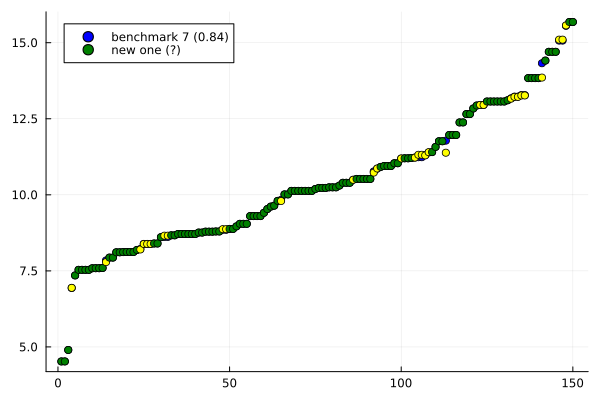

In [783]:
common_ids = intersect(data_17.id, average_data.id)
diff_ids = filter(id -> data_17[data_17.id .== id, :consommation] != average_data[average_data.id .== id, :consommation], common_ids)
data_1_common = filter(row -> row.id in common_ids, data_17)
data_2_common = filter(row -> row.id in common_ids, average_data)


data_1_sorted = sort(data_17, :consommation)
data_2_sorted = [average_data.consommation[i] for i in data_1_sorted.id]
#= data_3_sorted = [data_3.consommation[i] for i in data_1_sorted.id]
 =#
colors1 = [(i in common_ids ? :blue : :blue) for i in data_1_sorted.id]
colors2 = [(i in diff_ids ? :yellow : :green) for i in data_1_sorted.id]
#= colors3 = [(i in common_ids ? :black : :white) for i in data_1_sorted.id]
 =#

scatter(1:150, data_1_sorted.consommation, c=colors1, label="benchmark 7 (0.84)")
scatter!(1:150, data_2_sorted, c=colors2, label= "new one (?)")

In [784]:
uniqueD = get_unique_data(trainData, COLUMNS_TO_COMPARE_1)
uniqueD[ uniqueD.type .== "voiture_deux_places", : ]

#sort(trainData, :consommation, rev=true)

#essayer, plutot que d'enlever une colonne automatiquement, essayer de réduire le nb d'états possibles, ex : integrale => propulsion 

Row,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Abstract…,Int64,Float64,String15,String15,Float64
1,voiture_deux_places,8,5.0,integrale,automatique,13.0672
2,voiture_deux_places,6,3.0,propulsion,automatique,10.5223
3,voiture_deux_places,6,3.0,integrale,automatique,11.2005
4,voiture_deux_places,8,4.2,integrale,automatique,13.8359
5,voiture_deux_places,10,5.2,integrale,automatique,14.4124
6,voiture_deux_places,4,2.0,propulsion,automatique,9.04654
7,voiture_deux_places,8,5.0,propulsion,automatique,12.6546
8,voiture_deux_places,6,3.0,propulsion,manuelle,12.838
9,voiture_deux_places,8,6.2,propulsion,manuelle,13.1077


In [785]:
differentIds = [10
11
39
45
49
72
98
112
132]

9-element Vector{Int64}:
  10
  11
  39
  45
  49
  72
  98
 112
 132

In [786]:
idProblematiques = [57	
99	
109	
119]

testData[idProblematiques, :]
out[idProblematiques, :]

Row,id,consommation
,Int64,Float64
1,57,11.2005
2,99,11.2005
3,109,11.2005
4,119,11.2005
